# MMM: dDMPC-dDMPS-dChol + HSA

# Import Libraries & Set up Model

In [1]:
# use matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
import warnings

# Filter out FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, Parameters, process_chain, Transform, load_chain, possibly_create_parameter

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet, Component, sld_profile

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

import periodictable
from multiprocessing import Pool

# version numbers used in this analysis
refnx.version.version, scipy.version.version, np.version.version


('0.1.41', '1.11.4', '1.26.3')

In [2]:
# Load datasets for the bilayer at 37C before the addition of LDL and after the incubation and rinse
S1_data_d2o_rt = ReflectDataset('55777_78_S4_37C_D2O.dat')
S1_data_d2o_rt.name = "D2O_dataset"
S1_data_smw_rt = ReflectDataset('55785_86_S4_37C_SMW.dat')
S1_data_smw_rt.name = "SMW_dataset"
S1_data_h2o_rt = ReflectDataset('55797.raw_98.raw_S4_37C_H2O.dat')
S1_data_h2o_rt.name = "H2O_dataset"


S1_data_d2o_HSA = ReflectDataset('55884.raw_85.raw_S4_37C_D2O_HSA_8h_rinse.dat')
S1_data_d2o_HSA.name = "D2O_dataset"
S1_data_smw_HSA = ReflectDataset('55880.raw_81.raw_S4_37C_SMW_HSA_8h_rinse.dat')
S1_data_smw_HSA.name = "SMW_dataset"
S1_data_h2o_HSA = ReflectDataset('55876.raw_77.raw_S4_37C_H2O_HSA_8h_rinse.dat')
S1_data_h2o_HSA.name = "H2O_dataset"



In [3]:
# let the SiO2 slabs be defined outside this Component.
# the Bilayer Component describes layers of the bilayer
    def __init__(self, *pars):
        super().__init__(name='Bilayer_RT')
        
        self.pnames = ['heads_sld', 'heads_thick', 'heads_hydration',
                       'tails_sld', 'tails_thick', 'tails_hydration',
                       'outer_rough']
        
        self._pars = [possibly_create_parameter(a, name=pname) for pname, a in zip(self.pnames, pars)]        

        assert len(self._pars) == 7
        assert len(self.pnames) == 7
        
        for pname, a in zip(pnames, self._pars):
            setattr(self, pname, a)
    
        self._parameters = Parameters(data = self._pars, name=self.name)

    @property
    def parameters(self):
        return self._parameters

    def slabs(self, structure=None):
        """
        Slab representation of this component. See :class:`Component.slabs`
        """
        solvent = complex(structure.solvent)
        
        # Account for bilayer hydration
        rho_Heads = self.heads_hydration.value * solvent
        rho_Heads += (1 - self.heads_hydration.value) *  self.heads_sld.value

        rho_Tails = self.tails_hydration.value * solvent
        rho_Tails += (1 - self.tails_hydration.value) *  self.tails_sld.value
        

        
        orough = self.outer_rough.value

        bilayer_rt = np.array([
            [self.heads_thick.value, np.real(rho_Heads), np.imag(0), orough, 0],
            [self.tails_thick.value, np.real(rho_Tails), np.imag(0), orough, 0],
            [self.heads_thick, np.real(rho_Heads), np.imag(0), orough, 0],
        ], dtype=float)
    
        return np.r_[bilayer_rt]


In [4]:
pnames = [ 'heads_sld', 'heads_thick', 'heads_hydration',
           'tails_sld', 'tails_thick', 'tails_hydration',
           'outer_rough']

# Create Parameter objects to share between conditions. Reuse a Parameter object if it's common.
# if it's not common then create a new Parameter object for that condition.

base_pars = [('heads_sld',         1.9,   False, (0, 2)),
             ('heads_thick',        8, True, (0, 20)),
             ('heads_hydration',       0.5, True, (0, 1)),
             ('tails_sld',         7,   True, (4, 8)),
             ('tails_thick',        24, True, (0, 40)),
             ('tails_hydration',       0, True, (0, 1)),
             ('outer_rough',    4, True, (2, 7))]



pars = {p[0]: Parameter(value=p[1], vary=p[2], bounds=p[3], name=p[0]) for p in base_pars}

a = Bilayer(*(pars.values())) 

In [5]:
tails_hydration_HSA = Parameter(0.2, vary=True, name='tails_hydration_HSA', bounds=(0, 1))
pars['tails_hydration'] = tails_hydration_HSA

heads_hydration_HSA = Parameter(0.5, vary=True, name='heads_hydration_HSA', bounds=(0, 1))
pars['heads_hydration'] = heads_hydration_HSA

b = Bilayer(*(pars.values())) 

In [6]:
#Set substrate and bulk solvent parameters
si = SLD(2.07, 'Si')
sio2 = SLD(3.47, 'SiO2')

d2o = SLD(6.36, 'D2O')
h2o = SLD(-0.56, 'H2O')
smw = SLD(2.07, 'SMW')
fmw_a = SLD(4.0, 'FMWa')
fmw_b = SLD(4.0, 'FMWb')

d2o.real.setp(6.25, bounds=(6, 6.36), vary=True)
d2o.real.name='D2O SLD'

smw.real.setp(2.07, bounds=(1.5, 3), vary=True)
smw.real.name='SMW SLD'

h2o.real.setp(-0.56, bounds=(-0.56, 1), vary=True)
h2o.real.name='H2O SLD'


## Shared SiO2 layer ##
S1_l_sio2 = sio2(15, 3)

S1_l_sio2.thick.name = 'S1 SiO2 Thickness'
S1_l_sio2.thick.setp(13, bounds=(2, 30), vary=True)
S1_l_sio2.rough.name = name='S1 SiO2 Roughness'
S1_l_sio2.rough.setp(4, bounds=(0, 12), vary=True)
S1_l_sio2.vfsolv.name = 'S1 SiO2 Solvation'
S1_l_sio2.vfsolv.setp(0.1, bounds=(0., 0.5), vary=True)






# Bilayer at 37C
S1_s_d2o_rt =  si  | S1_l_sio2 | a | d2o  (0, a.outer_rough)
S1_s_smw_rt =  si  | S1_l_sio2 | a | smw  (0, a.outer_rough)
S1_s_h2o_rt =  si  | S1_l_sio2 | a | h2o  (0, a.outer_rough)

# Bilayer at 37C + HSA
S1_s_d2o_HSA =  si  | S1_l_sio2 | b | d2o  (0, b.outer_rough)
S1_s_smw_HSA =  si  | S1_l_sio2 | b | smw  (0, b.outer_rough)
S1_s_h2o_HSA =  si  | S1_l_sio2 | b | h2o  (0, b.outer_rough)

In [7]:
# Common scale and background parameters
S1_scale_rt = Parameter(1, 'S1_scale_rt')
S1_scale_rt.setp(0.8158, bounds=(0.8, 1.2), vary=True)

S1_scale_HSA = Parameter(1, 'S1_scale_rt')
S1_scale_HSA.setp(0.8158, bounds=(0.8, 1.2), vary=True)



bkg1 = Parameter(1e-6, 'Bkg1')
bkg1.setp(1e-6, bounds=(1e-8, 6e-5), vary=True)

bkg2 = Parameter(1e-6, 'Bkg2')
bkg2.setp(1e-6, bounds=(1e-8, 6e-5), vary=True)

bkg3 = Parameter(1e-6, 'Bkg3')
bkg3.setp(1e-6, bounds=(1e-8, 6e-5), vary=True)





S1_model_d2o_rt =  ReflectModel(S1_s_d2o_rt,  scale=S1_scale_rt,  bkg=bkg1,    dq=4, dq_type='constant')
S1_model_smw_rt =  ReflectModel(S1_s_smw_rt,  scale=S1_scale_rt,  bkg=bkg2,    dq=4, dq_type='constant')
S1_model_h2o_rt =  ReflectModel(S1_s_h2o_rt,  scale=S1_scale_rt,  bkg=bkg3,    dq=4, dq_type='constant')   

S1_model_d2o_HSA =  ReflectModel(S1_s_d2o_HSA,  scale=S1_scale_HSA,  bkg=bkg1,    dq=4, dq_type='constant')
S1_model_smw_HSA =  ReflectModel(S1_s_smw_HSA,  scale=S1_scale_HSA,  bkg=bkg2,    dq=4, dq_type='constant')
S1_model_h2o_HSA =  ReflectModel(S1_s_h2o_HSA,  scale=S1_scale_HSA,  bkg=bkg3,    dq=4, dq_type='constant')  


In [8]:
S1_objective_d2o_rt = Objective(  S1_model_d2o_rt,   S1_data_d2o_rt)
S1_objective_smw_rt = Objective(  S1_model_smw_rt,   S1_data_smw_rt)
S1_objective_h2o_rt = Objective(  S1_model_h2o_rt,   S1_data_h2o_rt)

S1_objective_d2o_HSA = Objective(  S1_model_d2o_HSA,   S1_data_d2o_HSA)
S1_objective_smw_HSA = Objective(  S1_model_smw_HSA,   S1_data_smw_HSA)
S1_objective_h2o_HSA = Objective(  S1_model_h2o_HSA,   S1_data_h2o_HSA)


S1_objective_h2o_rt.weighted = S1_objective_smw_rt.weighted = S1_objective_d2o_rt.weighted = S1_objective_h2o_HSA.weighted = S1_objective_smw_HSA.weighted = S1_objective_d2o_HSA.weighted = True

global_objective = GlobalObjective([S1_objective_d2o_rt,  S1_objective_smw_rt, S1_objective_h2o_HSA, S1_objective_d2o_HSA,  S1_objective_smw_HSA,   S1_objective_h2o_HSA, ])


# Structure

In [67]:
S1_slabs_rt_d2o = a.slabs( S1_s_d2o_rt)
S1_slabs_LDL_d2o = b.slabs( S1_s_d2o_HSA)


# Display the slab representations
print("\nS4 37C Bilayer Slabs D2O:")
print(S1_slabs_rt_d2o)

print("\nS4 HSA Bilayer Slabs D2O:")
print(S1_slabs_LDL_d2o)



S4 37C Bilayer Slabs D2O:
[[11.41037601  4.09903474  0.          5.96075374  0.        ]
 [30.58634441  5.72339581  0.          5.96075374  0.        ]
 [11.41037601  4.09903474  0.          5.96075374  0.        ]]

S4 HSA Bilayer Slabs D2O:
[[11.41037601  4.63431529  0.          5.96075374  0.        ]
 [30.58634441  5.81342781  0.          5.96075374  0.        ]
 [11.41037601  4.63431529  0.          5.96075374  0.        ]]


# Run Fit

In [10]:
fitter = CurveFitter(global_objective)

In [11]:
fitter.reset()

In [12]:
fitter.fit('differential_evolution', popsize=10, polish=True);

-5531.577810077897: : 96it [00:33,  2.85it/s] 


# Plots

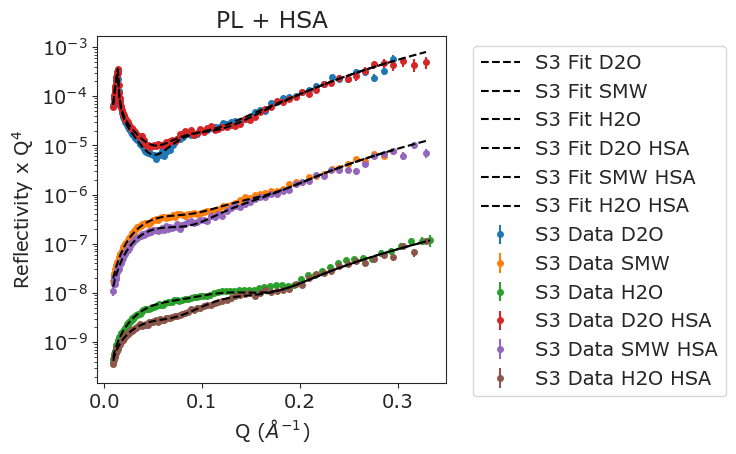

In [45]:
import matplotlib.pyplot as plt
import numpy as np  
plt.rcParams['font.family'] = 'Verdana'

# Define the offsets for each dataset
offsets = [4, 2, 0, 4, 2, 0]

marksize = 4
color = 'black'

# Define the scaling function
def scale_y(y, x):
    return y * x**4  # for R*Q^4

# Function to apply vertical offset
def apply_vertical_offset(y, offset):
    return y * 10**offset

# Create a single figure
fig, ax = plt.subplots(figsize=(4.5, 4.5))  # Adjusted for a single panel

# Define a list of objectives and labels for S1
S1_objectives = [S1_objective_d2o_rt, S1_objective_smw_rt,  S1_objective_h2o_rt, S1_objective_d2o_HSA, S1_objective_smw_HSA,  S1_objective_h2o_HSA]
S1_labels = ['D2O', 'SMW', 'H2O', 'D2O HSA', 'SMW HSA', 'H2O HSA']

# Loop over each objective and plot for S1
for i, S1_obj in enumerate(S1_objectives):
    x_S1, y_S1, y_err_S1 = S1_obj.data.x, S1_obj.data.y, S1_obj.data.y_err

    scaled_y_S1 = scale_y(apply_vertical_offset(y_S1, offsets[i]), x_S1)
    scaled_y_err_S1 = scale_y(apply_vertical_offset(y_err_S1, offsets[i]), x_S1)
    scaled_model_y_S1 = scale_y(apply_vertical_offset(S1_obj.model(x_S1), offsets[i]), x_S1)

    ax.errorbar(x_S1, scaled_y_S1, scaled_y_err_S1, label=f'S3 Data {S1_labels[i]}', fmt='o', markersize=marksize)
    ax.plot(x_S1, scaled_model_y_S1, label=f'S3 Fit {S1_labels[i]}', linestyle='--', color=color, zorder=10)

# Set y-axis scaling
ax.set_yscale('log')

# Set x-axis scaling
ax.set_xscale('linear')

# Set labels and legend
ax.set_xlabel('Q ($Å^{-1}$)', fontsize=14)
ax.set_ylabel('Reflectivity x Q$^{4}$', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('PL + HSA')


# Optionally, save the figure
plt.savefig('PL_HSA_fits', dpi=300, bbox_inches='tight')

plt.show()


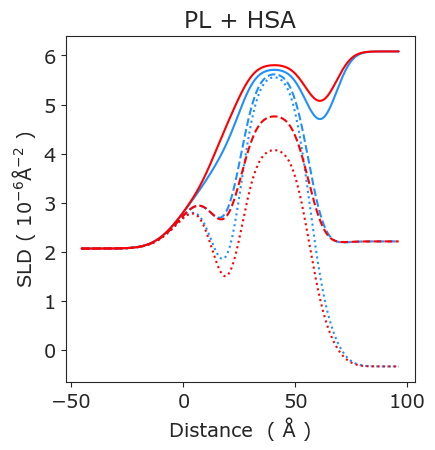

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 14 


fig, ax = plt.subplots(figsize=(4.5, 4.5))

# Plot S1 data on the left panel
ax.plot(*S1_s_d2o_rt.sld_profile(),  label='D2O_RT'  , linestyle='-', color= 'dodgerblue')
ax.plot(*S1_s_smw_rt.sld_profile(),  label='SMW_RT'  , linestyle='--', color='dodgerblue')
ax.plot(*S1_s_h2o_rt.sld_profile(),  label='H2O_RT'  , linestyle=':', color= 'dodgerblue')

ax.plot(*S1_s_d2o_HSA.sld_profile(),  label='D2O_HSA'  , linestyle='-', color= 'red')
ax.plot(*S1_s_smw_HSA.sld_profile(),  label='SMW_HSA'  , linestyle='--', color='red')
ax.plot(*S1_s_h2o_HSA.sld_profile(),  label='H2O_HSA'  , linestyle=':', color= 'red')



# Set labels and legends for both panels
ax.set_ylabel("SLD ( $10^{-6}$Å$^{-2}$ )")
ax.set_xlabel("Distance  ( Å )")
# ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_title('PL + HSA')



# Optionally, save the figure
# plt.savefig('PL_HSA_SLD', dpi=300, bbox_inches='tight')

plt.show()


# S1 VF Plots

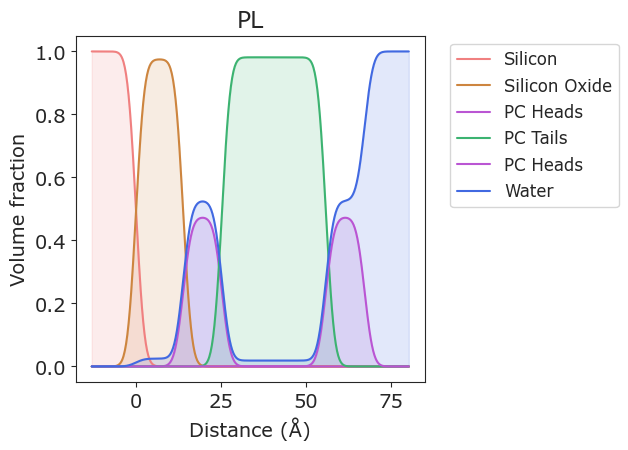

In [60]:
#Volume fraction plot of the bilayer at 37C
import seaborn as sns

# Set style
sns.set_style('ticks')

# Add custom labels to this list
custom_labels = ["Silicon", "Silicon Oxide", "PC Heads", "PC Tails", 'PC Heads', "Water"]  # Example labels
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 14 



def create_vfp(structure, solvent_slab=-1, roughness=2, labels=None):
    _slabs = structure.slabs().copy()

    if roughness is not None:
        _slabs[:, 3] = roughness
        
    # Create an array of hydration values for each slab in the structure
    vf = np.zeros(len(_slabs))

    # Assign hydration values to the layers of the Paracini component
    vf[0:5] = np.array([  0,
                          S1_l_sio2.vfsolv,
                          a.heads_hydration.value,
                          a.tails_hydration.value,
                          a.heads_hydration.value, ])
                                                                       

    vf = 1 - vf
    
    nvfp = len(_slabs)
    
    z, sldp = sld_profile(_slabs) 
    vfp = np.zeros((nvfp, len(z)), float)
    
    for i in range(len(_slabs)):
        _slabs[:, 1:3] = 0
        _slabs[i, 1] = vf[i]
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[i] = _vfp
    
    # fix up the solvent vfp
    _slabs[:, 1] = 1 - vf


    _slabs[solvent_slab, 1] = 1
    _vfp = sld_profile(_slabs, z=z)[1]
    vfp[solvent_slab] = _vfp

    return z, vfp

z, vfp = create_vfp(S1_s_d2o_rt, solvent_slab=-1, labels=custom_labels)

# Get the "Paired" color palette from Seaborn
# colors = sns.color_palette('husl', len(vfp))

custom_colors = ["lightcoral", "peru", "mediumorchid", "mediumseagreen", "mediumorchid", "royalblue"]


# Swap the colors of the last two elements

# Set the color of the last element to 'royalblue'

fig3 = plt.figure(figsize=(4.5, 4.5))

for i in range(len(vfp)):
    sns.lineplot(x=z, y=vfp[i], label=custom_labels[i], color=custom_colors[i])
    plt.fill_between(z, 0, vfp[i], color=custom_colors[i], alpha=0.15)  # Shading under the line plot
    plt.ylabel('Volume fraction')
    plt.xlabel('Distance (Å)')
    plt.xticks()  
    plt.yticks()  

# Adding a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.title('PL')


plt.savefig('PL_VF.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------EXPORT-----------------------------------------

import pandas as pd

# Function to create the volume fraction plot data
def create_vfp_data(z, vfp, labels):
    # Initialize a dictionary to store data
    data = {'Distance (Å)': z}
    
    # Add each volume fraction profile to the dictionary
    for i, label in enumerate(labels):
        data[label] = vfp[i]
    
    return pd.DataFrame(data)

# Generate the volume fraction profile data
z, vfp = create_vfp(S1_s_d2o_rt, solvent_slab=-1, labels=custom_labels)

# Create a DataFrame from the volume fraction profile data
vfp_data = create_vfp_data(z, vfp, custom_labels)

# Export the DataFrame to a CSV file
vfp_data.to_csv('S4_37C_volume_fraction_profiles.csv', index=False)

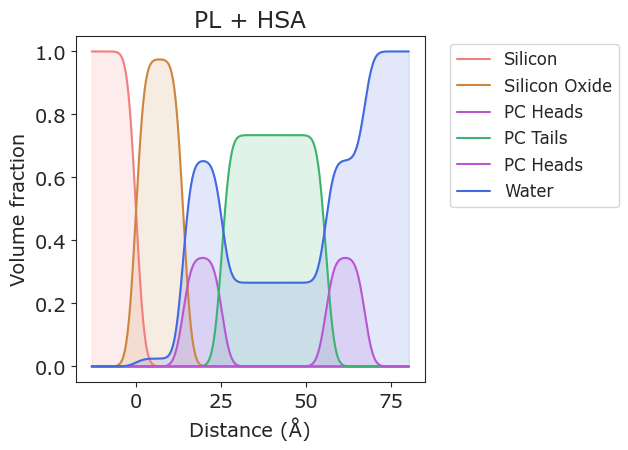

In [61]:
#Volume fraction plot of the bilayer at 37C + HSA
import seaborn as sns

# Set style
sns.set_style('ticks')

# Add custom labels to this list
custom_labels = ["Silicon", "Silicon Oxide", "PC Heads", "PC Tails", 'PC Heads', "Water"]  # Example labels
plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 14 



def create_vfp(structure, solvent_slab=-1, roughness=2, labels=None):
    _slabs = structure.slabs().copy()

    if roughness is not None:
        _slabs[:, 3] = roughness
        
    # Create an array of hydration values for each slab in the structure
    vf = np.zeros(len(_slabs))

    # Assign hydration values to the layers of the Paracini component
    vf[0:5] = np.array([  0,
                          S1_l_sio2.vfsolv,
                          b.heads_hydration.value,
                          b.tails_hydration.value,
                          b.heads_hydration.value, ])
                                                                       

    vf = 1 - vf
    
    nvfp = len(_slabs)
    
    z, sldp = sld_profile(_slabs) 
    vfp = np.zeros((nvfp, len(z)), float)
    
    for i in range(len(_slabs)):
        _slabs[:, 1:3] = 0
        _slabs[i, 1] = vf[i]
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[i] = _vfp
    
    # fix up the solvent vfp
    _slabs[:, 1] = 1 - vf


    _slabs[solvent_slab, 1] = 1
    _vfp = sld_profile(_slabs, z=z)[1]
    vfp[solvent_slab] = _vfp

    return z, vfp

z, vfp = create_vfp(S1_s_d2o_HSA, solvent_slab=-1, labels=custom_labels)

# Get the "Paired" color palette from Seaborn
custom_colors = ["lightcoral", "peru", "mediumorchid", "mediumseagreen", "mediumorchid", "royalblue"]

# Swap the colors of the last two elements

# Set the color of the last element to 'royalblue'

fig3 = plt.figure(figsize=(4.5, 4.5))

for i in range(len(vfp)):
    sns.lineplot(x=z, y=vfp[i], label=custom_labels[i], color=custom_colors[i])
    plt.fill_between(z, 0, vfp[i], color=custom_colors[i], alpha=0.15)  # Shading under the line plot
    plt.ylabel('Volume fraction')
    plt.xlabel('Distance (Å)')
    plt.xticks()  
    plt.yticks()  

# Adding a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.title('PL + HSA')


# plt.savefig('PL_VF_HSA.png', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------EXPORT-----------------------------------------

import pandas as pd

# Function to create the volume fraction plot data
def create_vfp_data(z, vfp, labels):
    # Initialize a dictionary to store data
    data = {'Distance (Å)': z}
    
    # Add each volume fraction profile to the dictionary
    for i, label in enumerate(labels):
        data[label] = vfp[i]
    
    return pd.DataFrame(data)

# Generate the volume fraction profile data
z, vfp = create_vfp(S1_s_d2o_rt, solvent_slab=-1, labels=custom_labels)

# Create a DataFrame from the volume fraction profile data
vfp_data = create_vfp_data(z, vfp, custom_labels)

# Export the DataFrame to a CSV file
vfp_data.to_csv('S1_37C_HSA_volume_fraction_profiles.csv', index=False)

# Error Analysis

In [17]:
fitter.reset()

In [18]:
res = fitter.sample(10, nthin=150, pool=1)

100%|███████████████████████████████████████| 1500/1500 [08:47<00:00,  2.84it/s]


# Corner Plot

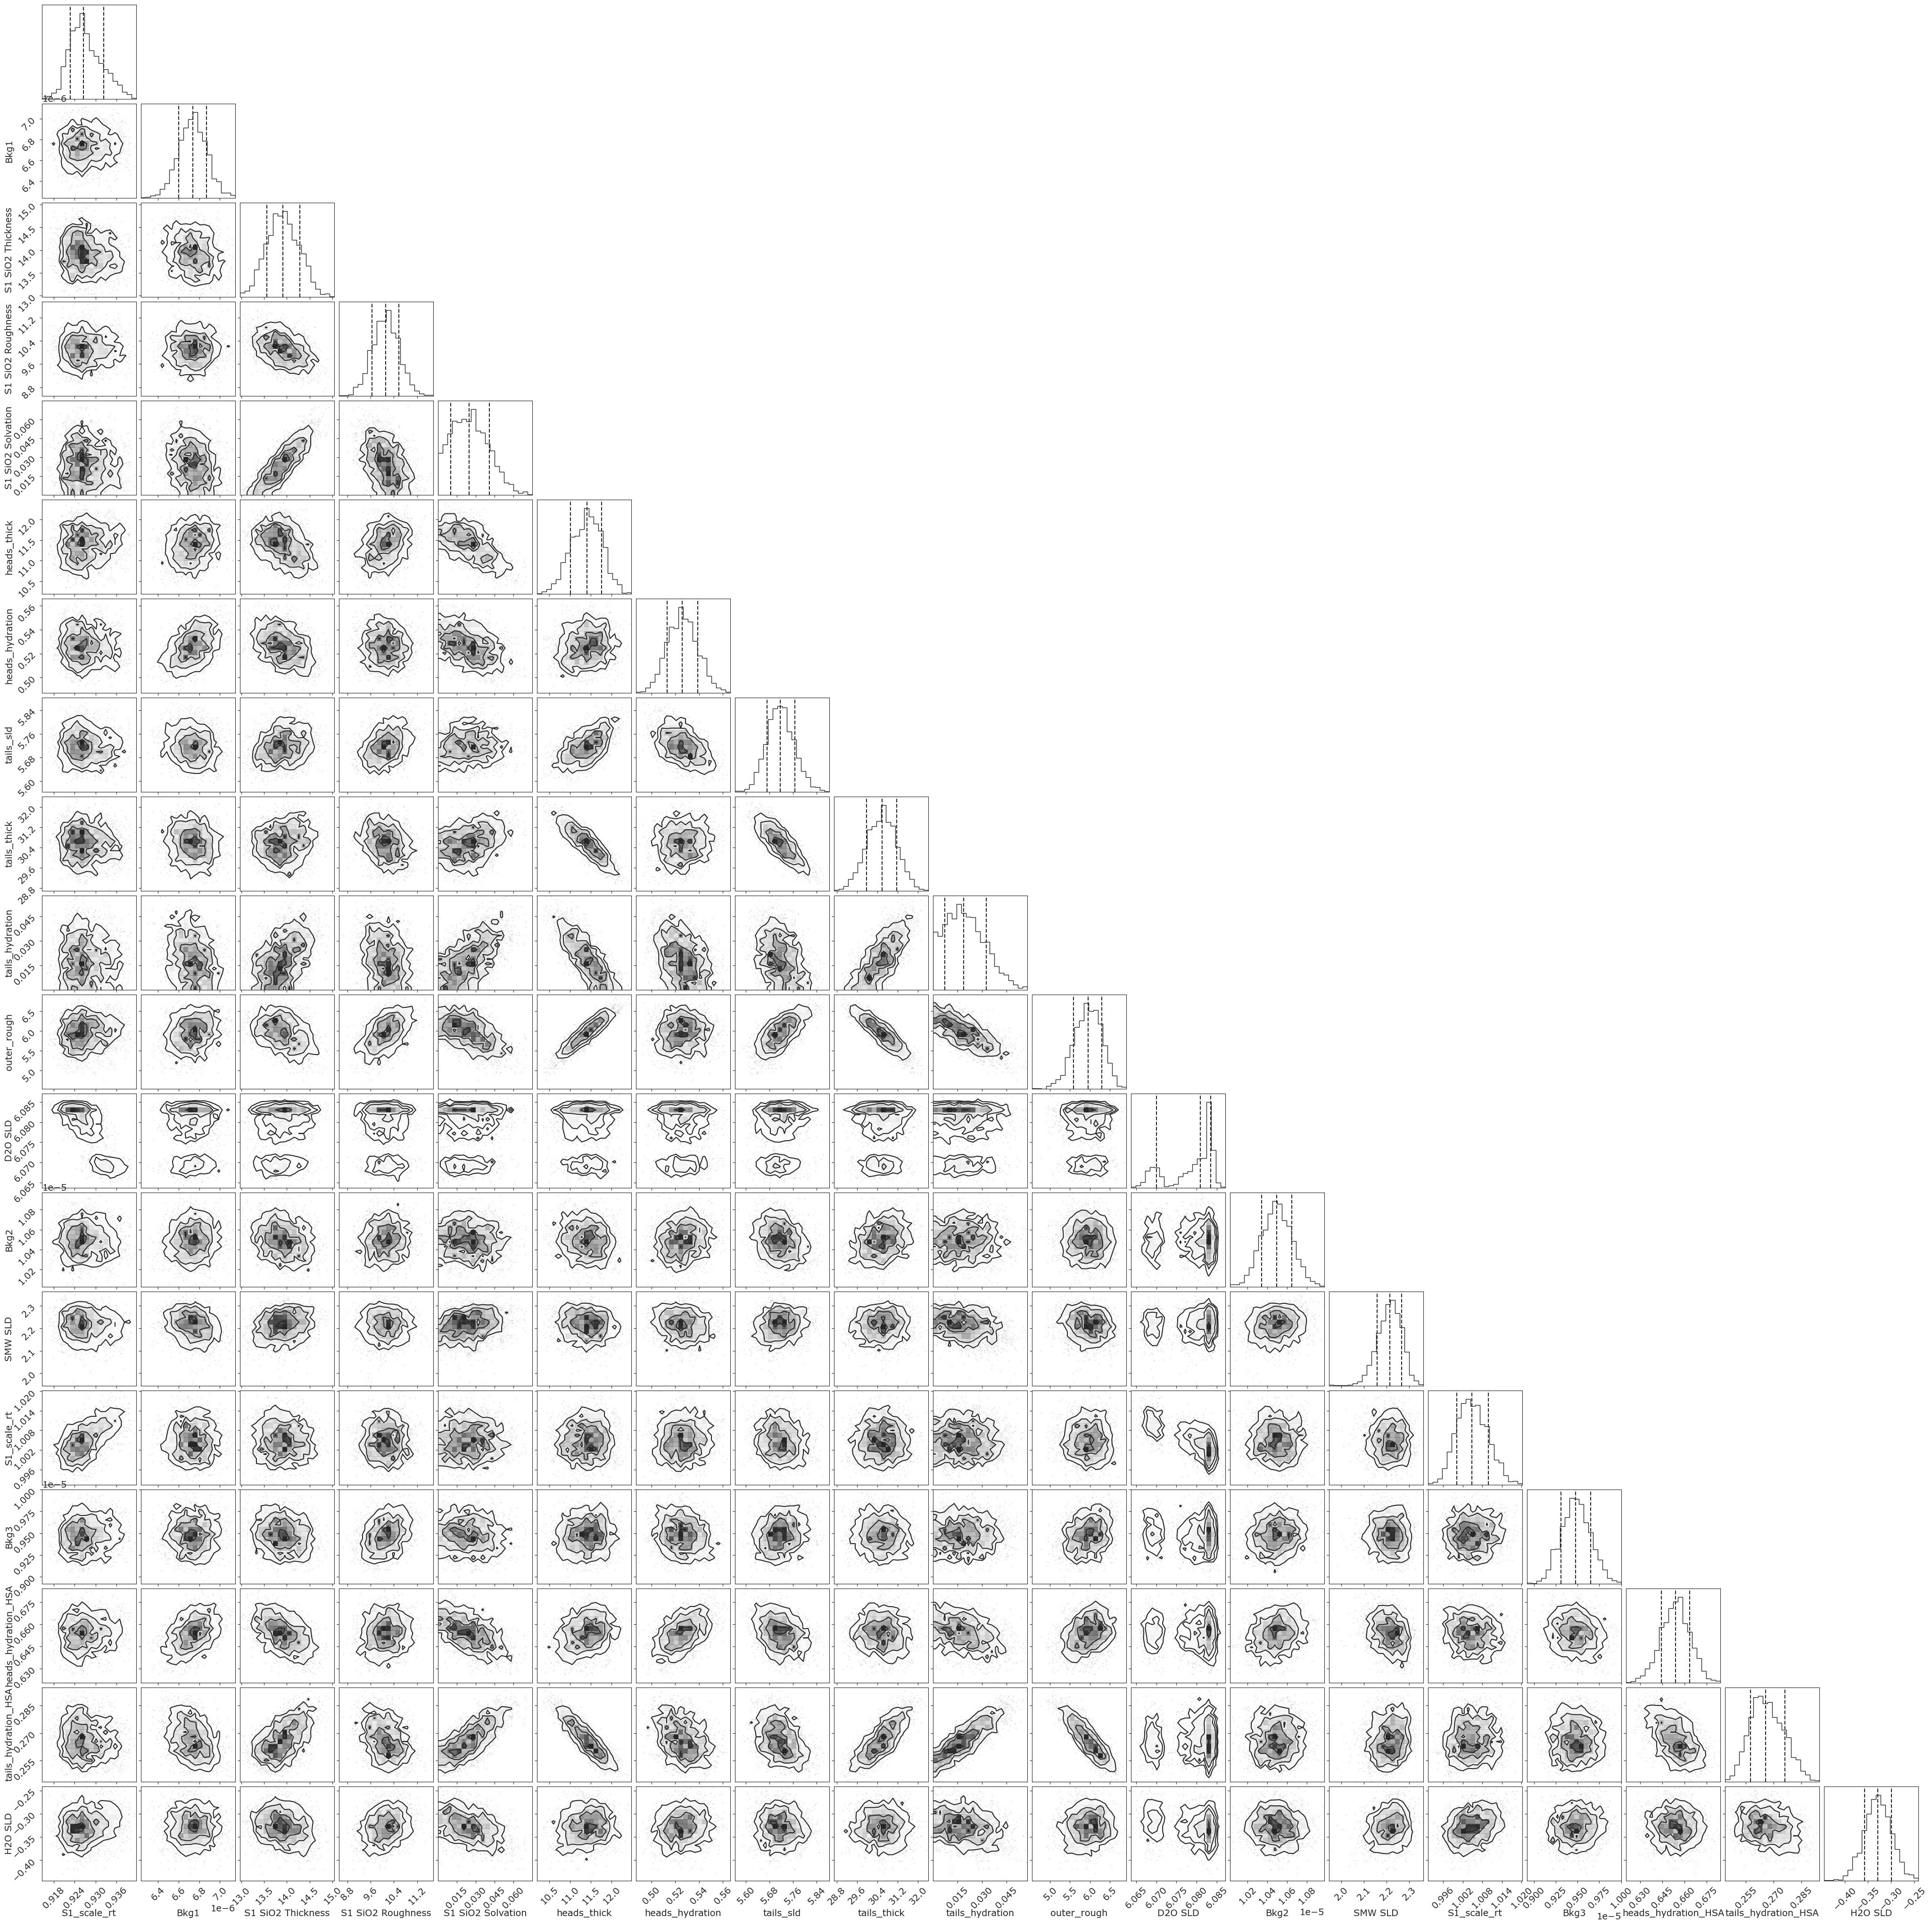

In [37]:
global_objective.corner();
# plt.savefig('PL_HSA_corner')

# Sampled SLD Profiles

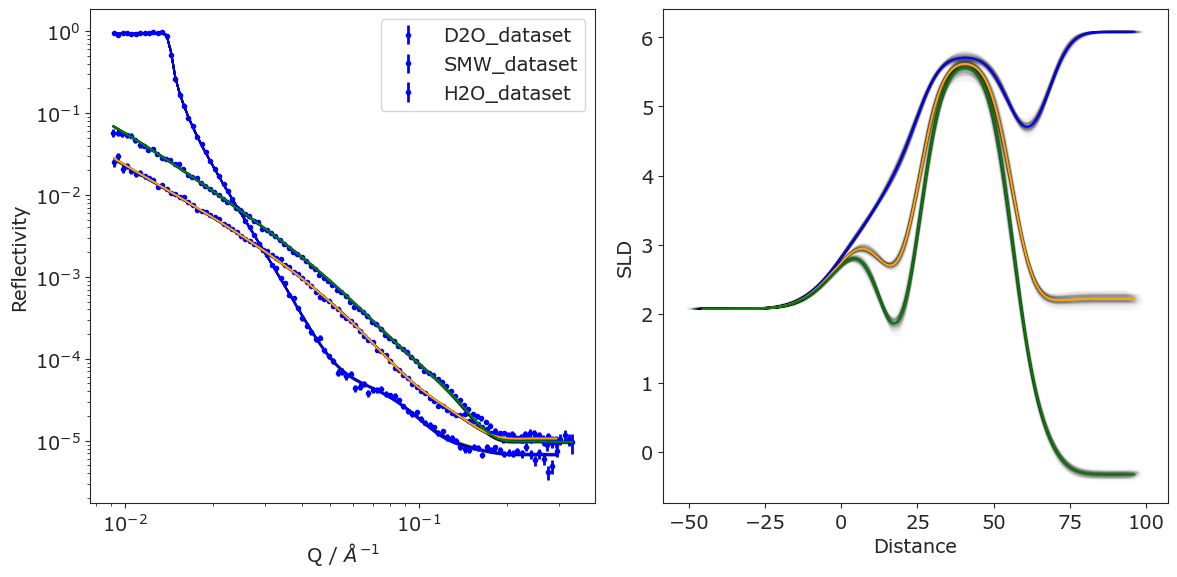

In [20]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting for Figure 1 on the first subplot
plt.sca(axs[0])  # Set the current axes to the first subplot
f, w = S1_objective_d2o_rt.plot(samples=200, fig=fig)
w.lines[-1].set_color('blue')
f, w = S1_objective_smw_rt.plot(samples=200, fig=fig)
w.lines[-1].set_color('orange')
f, w = S1_objective_h2o_rt.plot(samples=200, fig=fig)
w.lines[-1].set_color('green')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel('Q / $\AA^{-1}$')
axs[0].set_ylabel('Reflectivity')
axs[0].legend()

# Plotting for Figure 2 on the second subplot
plt.sca(axs[1])  # Set the current axes to the second subplot
f, w = S1_s_d2o_rt.plot(samples=200, fig=fig)
w.lines[-1].set_color('blue')
f, w = S1_s_smw_rt.plot(samples=200, fig=fig)
w.lines[-1].set_color('orange')
f, w = S1_s_h2o_rt.plot(samples=200, fig=fig)
w.lines[-1].set_color('green')

axs[1].set_yscale('linear')
axs[1].set_xscale('linear')
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('SLD')
# axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()


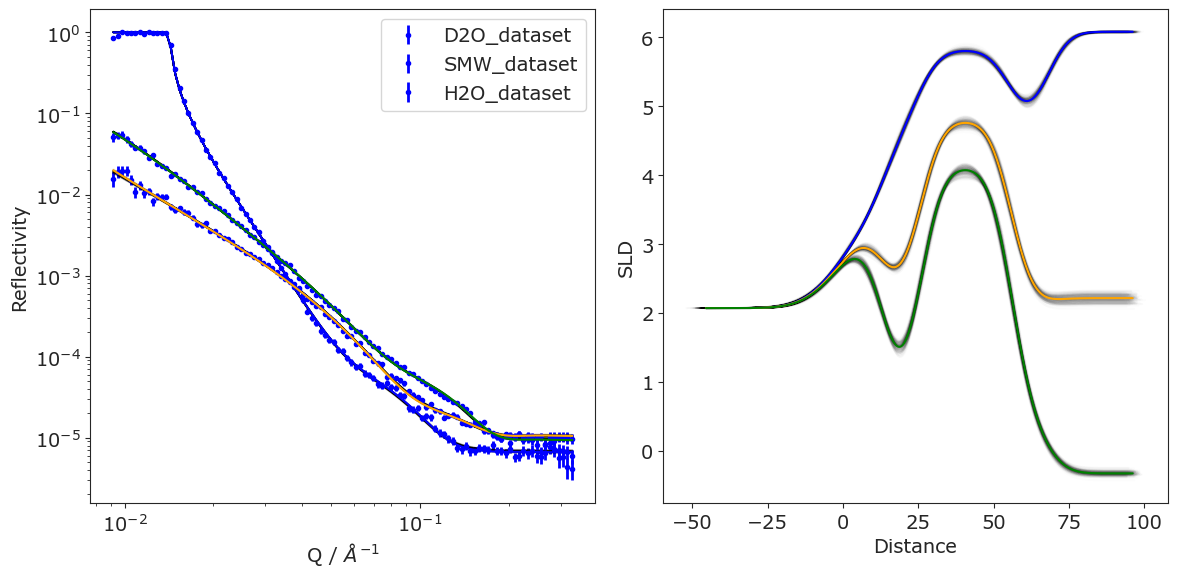

In [21]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting for Figure 1 on the first subplot
plt.sca(axs[0])  # Set the current axes to the first subplot
f, w = S1_objective_d2o_HSA.plot(samples=200, fig=fig)
w.lines[-1].set_color('blue')
f, w = S1_objective_smw_HSA.plot(samples=200, fig=fig)
w.lines[-1].set_color('orange')
f, w = S1_objective_h2o_HSA.plot(samples=200, fig=fig)
w.lines[-1].set_color('green')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel('Q / $\AA^{-1}$')
axs[0].set_ylabel('Reflectivity')
axs[0].legend()

# Plotting for Figure 2 on the second subplot
plt.sca(axs[1])  # Set the current axes to the second subplot
f, w = S1_s_d2o_HSA.plot(samples=200, fig=fig)
w.lines[-1].set_color('blue')
f, w = S1_s_smw_HSA.plot(samples=200, fig=fig)
w.lines[-1].set_color('orange')
f, w = S1_s_h2o_HSA.plot(samples=200, fig=fig)
w.lines[-1].set_color('green')

axs[1].set_yscale('linear')
axs[1].set_xscale('linear')
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('SLD')
# axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()


# Fitted Parameters

In [62]:
#Display only the values that have been fitted plus other useful metrics
fitted_parameters = global_objective.parameters.varying_parameters() # List varying parameters
print(fitted_parameters)
print("number of fitted parameters: ", len(fitted_parameters)) 

number_of_exp_points =  len(S1_data_d2o_rt) +  len(S1_data_smw_rt) +  len(S1_data_h2o_rt) 
number_of_exp_points += len(S1_data_d2o_HSA) +  len(S1_data_smw_HSA) +  len(S1_data_h2o_HSA)  


print(" Number of experimental points: ", number_of_exp_points)
number_of_fitted_par = len(fitted_parameters)
print(" Number of fitted parameters: ", number_of_fitted_par)

chisquared =  S1_objective_d2o_rt.chisqr() +  S1_objective_smw_rt.chisqr() +  S1_objective_h2o_rt.chisqr()
chisquared += S1_objective_d2o_HSA.chisqr() +  S1_objective_smw_HSA.chisqr() +  S1_objective_h2o_HSA.chisqr()

print(" chi^2 = ", chisquared)


print(" Reduced chi^2 = ", chisquared / (number_of_exp_points - number_of_fitted_par ))

________________________________________________________________________________
Parameters:      None      
<Parameter: 'S1_scale_rt' , value=0.926533 +/- 0.00483, bounds=[0.8, 1.2]>
<Parameter:    'Bkg1'     , value=6.73718e-06 +/- 1.35e-07, bounds=[1e-08, 6e-05]>
<Parameter:'S1 SiO2 Thickness', value=13.9132 +/- 0.365, bounds=[2.0, 30.0]>
<Parameter:'S1 SiO2 Roughness', value=10.1159 +/- 0.464, bounds=[0.0, 12.0]>
<Parameter:'S1 SiO2 Solvation', value=0.0248128 +/- 0.0154, bounds=[0.0, 0.5]>
<Parameter: 'heads_thick' , value=11.4104 +/- 0.38 , bounds=[0.0, 20.0]>
<Parameter:'heads_hydration', value=0.525962 +/- 0.0127, bounds=[0.0, 1.0]>
<Parameter:  'tails_sld'  , value=5.7166 +/- 0.0467, bounds=[4.0, 8.0]>
<Parameter: 'tails_thick' , value=30.5863 +/- 0.596, bounds=[0.0, 40.0]>
<Parameter:'tails_hydration', value=0.0186457 +/- 0.0128, bounds=[0.0, 1.0]>
<Parameter: 'outer_rough' , value=5.96075 +/- 0.353, bounds=[2.0, 7.0]>
<Parameter:   'D2O SLD'   , value=6.08098 +/- 0.00669, bo

# Save Table of Values

In [39]:
import re
import pandas as pd

# Define a function to round numbers, preserving original notation
def round_number(value, decimals):
    try:
        original_value = float(value)
        # Check if the value is in scientific notation
        if "e" in value.lower():
            format_string = "{:." + str(decimals) + "e}"
        else:
            format_string = "{:." + str(decimals) + "f}"
        return format_string.format(original_value)
    except ValueError:
        return value

# Number of decimals to round to
decimals = 2  # You can change this to your desired number of decimal places

# Defining script_output
script_output = """
Parameters: 'instrument parameters'

________________________________________________________________________________
Parameters:      None      
<Parameter: 'S1_scale_rt' , value=0.926533 +/- 0.00483, bounds=[0.8, 1.2]>
<Parameter:    'Bkg1'     , value=6.73718e-06 +/- 1.35e-07, bounds=[1e-08, 6e-05]>
<Parameter:'S1 SiO2 Thickness', value=13.9132 +/- 0.365, bounds=[2.0, 30.0]>
<Parameter:'S1 SiO2 Roughness', value=10.1159 +/- 0.464, bounds=[0.0, 12.0]>
<Parameter:'S1 SiO2 Solvation', value=0.0248128 +/- 0.0154, bounds=[0.0, 0.5]>
<Parameter: 'heads_thick' , value=11.4104 +/- 0.38 , bounds=[0.0, 20.0]>
<Parameter:'heads_hydration', value=0.525962 +/- 0.0127, bounds=[0.0, 1.0]>
<Parameter:  'tails_sld'  , value=5.7166 +/- 0.0467, bounds=[4.0, 8.0]>
<Parameter: 'tails_thick' , value=30.5863 +/- 0.596, bounds=[0.0, 40.0]>
<Parameter:'tails_hydration', value=0.0186457 +/- 0.0128, bounds=[0.0, 1.0]>
<Parameter: 'outer_rough' , value=5.96075 +/- 0.353, bounds=[2.0, 7.0]>
<Parameter:   'D2O SLD'   , value=6.08098 +/- 0.00669, bounds=[6.0, 6.36]>
<Parameter:    'Bkg2'     , value=1.04943e-05 +/- 1.52e-07, bounds=[1e-08, 6e-05]>
<Parameter:   'SMW SLD'   , value=2.21561 +/- 0.0539, bounds=[1.5, 3.0]>
<Parameter: 'S1_scale_rt' , value=1.00473 +/- 0.00485, bounds=[0.8, 1.2]>
<Parameter:    'Bkg3'     , value=9.47973e-06 +/- 1.71e-07, bounds=[1e-08, 6e-05]>
<Parameter:'heads_hydration_HSA', value=0.653989 +/- 0.00969, bounds=[0.0, 1.0]>
<Parameter:'tails_hydration_HSA', value=0.265731 +/- 0.00936, bounds=[0.0, 1.0]>
<Parameter:   'H2O SLD'   , value=-0.328273 +/- 0.0292, bounds=[-0.56, 1.0]>
number of fitted parameters:  19
 Number of experimental points:  625
 Number of fitted parameters:  19
 chi^2 =  1152.2761784111176
 Reduced chi^2 =  1.9014458389622402
_________________________________________________________________________________

"""

# Extracting parameters_info again
parameters_info = re.findall(r'<Parameter:.*?>', script_output)

# Extracting the values
parameter_data = []
for parameter in parameters_info:
    name = re.search(r"'(.*?)'", parameter).group(1)
    value_match = re.search(r'value=([-+]?\d+(\.\d+)?(e[-+]?\d+)?)', parameter)
    error_match = re.search(r'\+/-\s*([-+]?\d+(\.\d+)?(e[-+]?\d+)?)', parameter)
    
    value = round_number(value_match.group(1), decimals) if value_match else 'NA'
    error = '±' + round_number(error_match.group(1), decimals) if error_match else 'NA'
    
    # Extract bounds information or set to "NA" if value is fixed
    bounds_match = re.search(r'bounds=\[(.*?)\]', parameter)
    bounds = bounds_match.group(1).split(', ') if bounds_match else 'NA'
    
    parameter_data.append({'Parameter': name, 'Value': value, 'Error': error, 'Bounds': bounds})

# Creating the Pandas DataFrame
df = pd.DataFrame(parameter_data)

# Save to CSV
df.to_csv('PL_HSA_table.csv', index=False)


# Save Objectives

In [66]:
import pickle

# List of your objectives
ss = [S1_objective_d2o_rt,  S1_objective_smw_rt,  S1_objective_h2o_rt, 
      S1_objective_d2o_HSA,  S1_objective_smw_HSA,  S1_objective_h2o_HSA]

# Corresponding names for the files
names = ['S4_objective_d2o_rt',  'S4_objective_smw_rt',  'S4_objective_h2o_rt', 
         'S4_objective_d2o_HSA',  'S4_objective_smw_HSA',  'S4_objective_h2o_HSA']

# Create a dictionary mapping names to objects
sobjective_dict = dict(zip(names, ss))

# Iterate through the dictionary and pickle each object, also save its representation
for name, obj in sobjective_dict.items():
    # Save the binary serialized object
    with open(f'saved_{name}.pkl', 'wb+') as f:
        pickle.dump(obj, f)
    
    # Save the human-readable representation
    with open(f'saved_{name}_repr.txt', 'w+') as f:
        f.write(repr(obj))


# Save Data and Fits

In [64]:
import pandas as pd

# Function to add dataset columns to the DataFrame
def add_dataset_columns(df, y, y_err, model_y, label):
    df[f'{label} Y'] = y[:85]  # Truncate to 85 data points
    df[f'{label} Y Error'] = y_err[:85]
    df[f'{label} Model Y'] = model_y[:85]
    return df

# Initialize an empty DataFrame with the shared x-axis values from the first dataset
x_values = S1_objectives[0].data.x[:85]  # Truncate to 85 data points
all_data = pd.DataFrame({'X': x_values})

# Loop over each objective and add columns to the DataFrame
for i, S1_obj in enumerate(S1_objectives):
    y_S1, y_err_S1 = S1_obj.data.y, S1_obj.data.y_err
    model_y_S1 = S1_obj.model(S1_objectives[0].data.x[:85])  # Truncate model y-values to 85


    # Add columns for S1 and S3 to the DataFrame
    all_data = add_dataset_columns(all_data, y_S1, y_err_S1, model_y_S1, f'{S1_labels[i]}')

# Export the DataFrame to a CSV file
all_data.to_csv('Data_Fits_MMM_HSA.csv', index=False)


# Save SLD profiles

In [65]:
import pandas as pd

# Initialize a list to hold all the DataFrames
all_sld_data = []

# List of structures and their labels
structures = [S1_s_d2o_rt,  S1_s_smw_rt,  S1_s_h2o_rt, 
              S1_s_d2o_HSA, S1_s_smw_HSA, S1_s_h2o_HSA]

labels = ['S4 D2O_37C',  'S4 SMW_37C',  'S4 H2O_37C', 
          'S4 D2O_HSA', 'S4 SMW_HSA', 'S4 H2O_HSA']

# Loop over each structure and create DataFrames
for structure, label in zip(structures, labels):
    x, y = structure.sld_profile()
    sld_df = pd.DataFrame({'x': x, f'y_{label}': y})
    all_sld_data.append(sld_df)

# Concatenate all the DataFrames in the list
final_sld_df = pd.concat(all_sld_data, axis=1)

# Removing duplicate x columns
final_sld_df = final_sld_df.loc[:,~final_sld_df.columns.duplicated()]

# Save to CSV
final_sld_df.to_csv('Combined_sld_profiles_MMM_HSA.csv', index=False)


In [68]:
import numpy as np
import pandas as pd
import re

# Function to convert string representation of arrays to numpy arrays
def str_to_np_array(data_str):
    data_str = data_str.strip().replace('\n', '; ')
    return np.matrix(data_str)

# Function to round the dataframe values to two decimal places
def round_dataframe(df, decimals=2):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].apply(lambda x: round(x, decimals))
    return df

# Your input string
input_str = '''
S4 37C Bilayer Slabs D2O:
[[11.41037601  4.09903474  0.          5.96075374  0.        ]
 [30.58634441  5.72339581  0.          5.96075374  0.        ]
 [11.41037601  4.09903474  0.          5.96075374  0.        ]]

S4 HSA Bilayer Slabs D2O:
[[11.41037601  4.63431529  0.          5.96075374  0.        ]
 [30.58634441  5.81342781  0.          5.96075374  0.        ]
 [11.41037601  4.63431529  0.          5.96075374  0.        ]]
'''

# Splitting the input string into separate sections
sections = re.split(r'\n\n', input_str.strip())

# Creating DataFrame for each section and concatenating them
all_data = pd.DataFrame()
for section in sections:
    title, data_str = section.split(':')
    data = str_to_np_array(data_str)
    df = pd.DataFrame(data)
    df.insert(0, 'Title', title)
    all_data = pd.concat([all_data, df])

# Drop columns where all values are 0.0
all_data = all_data.loc[:, (all_data != 0.0).any(axis=0)]

# Renaming columns
column_names = ['Title', 'Thickness', 'SLD', 'Roughness']
all_data.columns = column_names[:len(all_data.columns)]

# Resetting the index
all_data.reset_index(drop=True, inplace=True)

# Round the numerical values in the dataframe
all_data = round_dataframe(all_data, decimals=2)

# Export to CSV
csv_file_path = 'Matrix_data_HSA.csv'
all_data.to_csv(csv_file_path, index=False)

print(f"Data exported to {csv_file_path}")


Data exported to Matrix_data_HSA.csv
